# Online payment fraud detection - ML project
## Doris BAILLARD

# 0 - Imports and dataset loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from collections import Counter
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Here I load the dataset
df = pd.read_csv('fraud-detection.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 1 - EDA 

Notes : the dataset is composed of 11 columns and +6M rows

columns : 
- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction
- isFlaggedFraud : fraud detections to correct

In [3]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


(None, (6362620, 11))

In [4]:
df.isna().sum() # no missing values 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.duplicated().sum() # no duplicated values 

0

## Focus on the type of payment

In [6]:
df.type.value_counts()
# notes :
#types of payment in the dataset which are : 'CASH_OUT','PAYMENT','CASH_IN', 'TRANSFER', 'DEBIT'
#We can notice than the largest part of the transactions corresponds to cash out

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [7]:
df[df.isFraud == 1]['isFraud'].count() #isolates the fraudulent cases

8213

In [8]:
df[df.isFraud == 1]['type'].value_counts() #shows which type of payment is more likely to be fraudulent in the dataset

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

<AxesSubplot:title={'center':'Focused on frauds'}, xlabel='type', ylabel='count'>

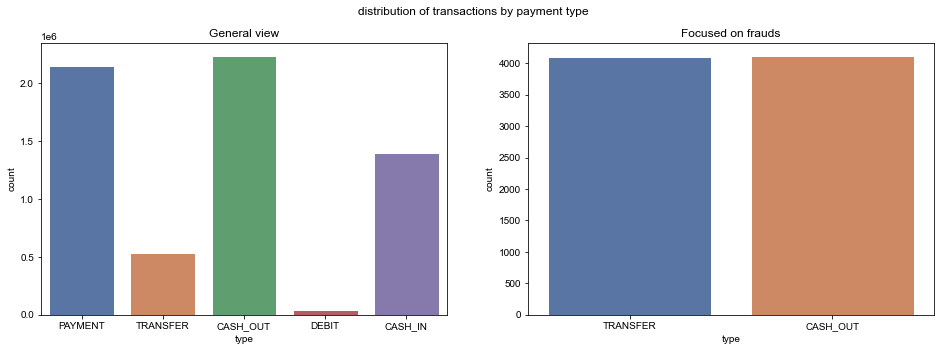

In [9]:
#Let's plot the distribution of the type of payment 
fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('distribution of transactions by payment type')
axes[0].set_title('General view')
axes[1].set_title('Focused on frauds')

#general view
sns.set(style="whitegrid")
sns.countplot(ax=axes[0],x=df["type"])


#focused on frauds
sns.set(style="whitegrid")
sns.countplot(ax=axes[1],x=df[df.isFraud == 1]['type'])


## Focus on the amounts 

In [10]:
df.amount.describe() 
#here are the stats for the amounts

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [11]:
#for more details:

print("The minimal amount of transaction in the dataset is : " + str(df.amount.min()))
print("The maximal amount is : "+ str(df.amount.max()))
print("The average amount is : "+ str(df.amount.mean()))

The minimal amount of transaction in the dataset is : 0.0
The maximal amount is : 92445516.64
The average amount is : 179861.90354913071


In [12]:
df.amount.value_counts() #The majority of the transactions have an amount of 10M dollars

10000000.00    3207
10000.00         88
5000.00          79
15000.00         68
500.00           65
               ... 
8513.48           1
189137.90         1
1615.78           1
128891.19         1
12257.89          1
Name: amount, Length: 5316900, dtype: int64

## Focus on detected frauds and real frauds


In [13]:
df.isFraud.value_counts() #true frauds

0    6354407
1       8213
Name: isFraud, dtype: int64

In [14]:
df.isFlaggedFraud.value_counts() #only 16 transactions have been detected as frauds against 8213 real frauds

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

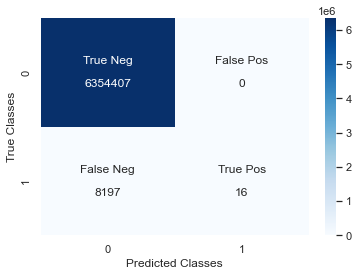

In [15]:
cf_matrix = confusion_matrix(df.isFraud,df.isFlaggedFraud)
#print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels,fmt='',cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

In [16]:
# Ratio of positives (fraud yes = 1) & negatives (no fraud = 0)

#real frauds
print("% of negatives & positives in the original dataset")
print(round((df["isFraud"].value_counts()/len(df))*100, ndigits=2))

% of negatives & positives in the original dataset
0    99.87
1     0.13
Name: isFraud, dtype: float64


In [17]:
#predictions :

print("% of negatives & positives in the original dataset")
print(round((df["isFlaggedFraud"].value_counts()/len(df))*100, ndigits=4))

% of negatives & positives in the original dataset
0    99.9997
1     0.0003
Name: isFlaggedFraud, dtype: float64


#### Explanation :
- True Negative : corresponds to non-fraudulent transactions that have been detected as such. These predictions are 99% accurate. That is, in 99% of the cases we can distinguish non-fraudulent transactions
- False Negative : corresponds to the result where the model incorrectly predicts the negative class : generally the model doesn't find the frauds.
- False Positive : corresponds to a result where the model incorrectly predicts the positive class.
- True Positive : corresponds to real frauds detected in "isflaggedFrauds"(16 on 8K frauds).

observation: current predictions are wrong

### Notes : 
My target is the column "isFraud". It is binary => only two classes :

"0" for a non-fraudulent transaction
"1" for a fraudulent one.

My target is imbalanced : 0.13% of the transactions are fraudulent, and only 0.0003% are detected as so which is insignificant.

# Construction of ML models for fraud detection

We are going to test different models to see  which one has the best results for detecting the frauds.


### But first : Data preparation

2 steps : 
- create dummies for objects (only if we keep the columns)
- drop unnecessary columns

In [18]:
#create dummies for the column "type"
df = pd.get_dummies(df, prefix=None,columns=['type'], drop_first=True)
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,1,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,1


In [19]:
df = df.drop(columns = ['step','isFlaggedFraud','nameOrig','nameDest']) 
#I decided to drop these columns as I won't need them

In [20]:
x = df.drop(columns = ['isFraud']) 
y = df.isFraud #the column 'isFraud' is my target, I keep it as 'y'. The rest of the features belong to 'x'.

In [21]:
x.shape,y.shape #checking the shapes

((6362620, 9), (6362620,))

In [22]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.2)

In [23]:
#check shape again
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1272524, 9), (1272524,), (5090096, 9), (5090096,))

### Logistic regression

In [24]:
lr_model= LogisticRegression(solver= 'liblinear')
lr_model.fit(X_train,y_train)
lr_pred = lr_model.predict(X_test)

print ("Classification Report:")
print (classification_report(y_test, lr_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083486
           1       0.41      0.71      0.52      6610

    accuracy                           1.00   5090096
   macro avg       0.71      0.85      0.76   5090096
weighted avg       1.00      1.00      1.00   5090096



In [25]:
def auprc(y_true, y_pred, plot=False):
    
    """A function that returns the area under the precision-recall curve (AUPRC) score of the model.
    
    Inputs
    -----------
    > y_true : the labels of the test set.
    > y_pred : the predicted labels, in probability form
    > plot : wether to print the precision-recall curve plot. Default=False"""
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    if plot == True:
        print(plt.plot(recall, precision), plt.title('Precision-Recall Curve'),plt.ylabel('True Positive Rate'),plt.xlabel('False Positive Rate'))
    return auc(recall, precision)

ROC AUC Score= 0.8522168130836478
[<matplotlib.lines.Line2D object at 0x0000024F2E7E26E0>] Text(0.5, 1.0, 'Precision-Recall Curve') Text(0, 0.5, 'True Positive Rate') Text(0.5, 0, 'False Positive Rate')


0.5585539931936313

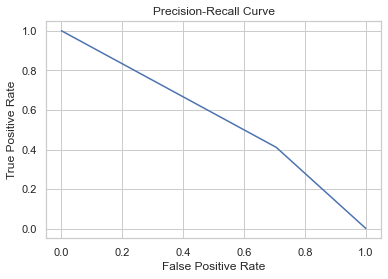

In [26]:
print ("ROC AUC Score=",roc_auc_score(y_test, lr_pred))

auprc(y_test,  lr_pred, plot=True)

[[5076800    6686]
 [   1945    4665]]


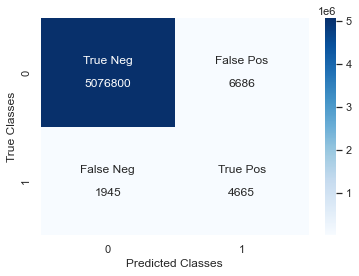

In [27]:
cf_matrix_lr = confusion_matrix(y_test, lr_pred)
print(cf_matrix_lr)

group_names_lr = ['True Neg','False Pos','False Neg','True Pos']
group_counts_lr = ['{0:0.0f}'.format(value) for value in
                cf_matrix_lr.flatten()]
labels_lr = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_names_lr,group_counts_lr)]
labels_lr = np.asarray(labels_lr).reshape(2,2)

sns.heatmap(cf_matrix_lr, annot=labels_lr,fmt='',cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

### Random Forest classifier

In [28]:
rf = RandomForestClassifier()

In [29]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [30]:
rf_predict = rf.predict(X_test)

In [31]:
print ("Classification Report:")
print (classification_report(y_test, rf_predict))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083486
           1       0.97      0.76      0.85      6610

    accuracy                           1.00   5090096
   macro avg       0.98      0.88      0.92   5090096
weighted avg       1.00      1.00      1.00   5090096



ROC Auc score:  0.8791808736133214
[<matplotlib.lines.Line2D object at 0x0000024F2E906170>] Text(0.5, 1.0, 'Precision-Recall Curve') Text(0, 0.5, 'True Positive Rate') Text(0.5, 0, 'False Positive Rate')


0.8623961062095782

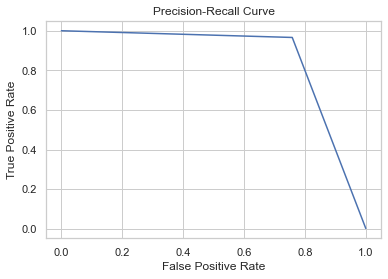

In [32]:
print("ROC Auc score: ", roc_auc_score(y_test, rf_predict))
#plotter la roc + explications
auprc(y_test, rf_predict, plot=True)

[[5083310     176]
 [   1597    5013]]


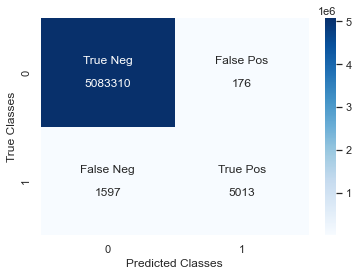

In [33]:
cf_matrix_rf = confusion_matrix(y_test, rf_predict)
print(cf_matrix_rf)

group_names_rf = ['True Neg','False Pos','False Neg','True Pos']
group_counts_rf = ['{0:0.0f}'.format(value) for value in
                cf_matrix_rf.flatten()]
labels_rf = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_names_rf,group_counts_rf)]
labels_rf = np.asarray(labels_rf).reshape(2,2)

sns.heatmap(cf_matrix_rf, annot=labels_rf,fmt='',cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

### LightGBM

What is LightGBM ? Light GBM is a gradient boosting framework that uses tree based learning algorithm.

Why did I choose LightGBM ?

LightGBM is an algorithm that works well on large datasets, such as the one I'm currently working on (more than 6 million rows x 10 columns.
It is also relatively good at handling imbalanced data, although the level of imbalance in this dataset (99,8% of class 0 vs 0,13% of class 1) might prove too much for it to handle. 


###  Sampling for detection
Objectives :
As we noticed earlier, the data are unbalanced. Indeed, there are clearly more transactions detected as "non-fraudulent" than fraudulent ones. 
In order to train our algorithm in an optimal way, we will proceed to a balanced sampling.

Moreover : the dataset is hudge : more than 6M values. 
Undersampling will help

### Light GBM with undersampling

In [34]:
sampler = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
# sampling ration is 1, means equal share of classes 

In [35]:
undersampled_x, undersampled_y = sampler.fit_resample(x, y)

In [36]:
undersampled_x.shape, undersampled_y.shape

((16426, 9), (16426,))

In [37]:
df.isFraud.value_counts() 
#as we can see,the original dataset is unbalanced with 8K fraudulent transactions against 6M non-fraudulent

0    6354407
1       8213
Name: isFraud, dtype: int64

In [38]:
undersampled_y.value_counts()
#here with the undersampler we got as many fraudulent and non-fraudulent

0    8213
1    8213
Name: isFraud, dtype: int64

In [39]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(undersampled_x, undersampled_y, random_state = 42, train_size = 0.2)

In [40]:
X_train_under.shape, X_test_under.shape, y_train_under.shape, y_test_under.shape

((3285, 9), (13141, 9), (3285,), (13141,))

In [41]:
lg = lgb.LGBMClassifier(max_depth = 10, learning_rate = 0.1, reg_alpha = 0.3,
                       reg_lambda = 0.5)
lg.fit(X_train, y_train)
y_pred_lg = lg.predict(X_test)

In [42]:
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083486
           1       0.96      0.76      0.85      6610

    accuracy                           1.00   5090096
   macro avg       0.98      0.88      0.92   5090096
weighted avg       1.00      1.00      1.00   5090096



In [43]:
y_pred_lg.shape

(5090096,)

ROC AUC Score= 0.8522168130836478
[<matplotlib.lines.Line2D object at 0x0000024F49B1E6E0>] Text(0.5, 1.0, 'Precision-Recall Curve') Text(0, 0.5, 'True Positive Rate') Text(0.5, 0, 'False Positive Rate')


0.8586412505517146

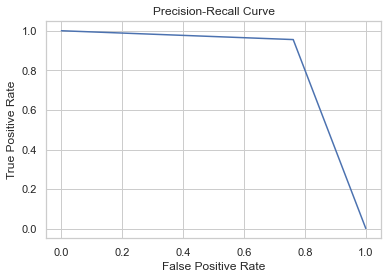

In [44]:
#roc auc score + plot
print ("ROC AUC Score=",roc_auc_score(y_test, lr_pred))

auprc(y_test,  y_pred_lg, plot=True)

[[5083251     235]
 [   1576    5034]]


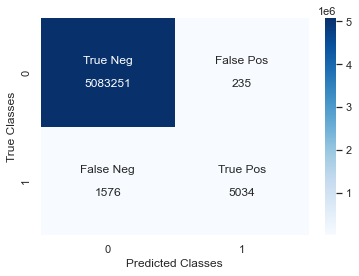

In [45]:
cf_matrix_lg = confusion_matrix(y_test,  y_pred_lg)
print(cf_matrix_lg)

group_names_lg = ['True Neg','False Pos','False Neg','True Pos']
group_counts_lg = ['{0:0.0f}'.format(value) for value in
                cf_matrix_lg.flatten()]
labels_lg = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_names_lg,group_counts_lg)]
labels_lg = np.asarray(labels_lg).reshape(2,2)

sns.heatmap(cf_matrix_lg, annot=labels_lg,fmt='',cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

### testing random Oversampler with SMOTE

In [46]:
X_train_os, y_train_os = SMOTE(sampling_strategy=0.5, k_neighbors=5, 
                               random_state=1).fit_resample(x, y)

In [47]:
Counter(y_train_os) #checks the  shape of y_train 
#we can notice than the SMOTE has inflated the number of fraudulent cases. We are now up to more than 3 million cases instead of 8000

Counter({0: 6354407, 1: 3177203})

In [48]:
lg_SMOTE = lgb.LGBMClassifier(max_depth = 10, learning_rate = 0.1, reg_alpha = 0.1,
                       reg_lambda = 0.3)
lg_SMOTE.fit(X_train_os, y_train_os)
y_pred_os = lg_SMOTE.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred_os))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083486
           1       0.26      1.00      0.41      6610

    accuracy                           1.00   5090096
   macro avg       0.63      1.00      0.70   5090096
weighted avg       1.00      1.00      1.00   5090096



ROC AUC Score= 0.99618130573784
[<matplotlib.lines.Line2D object at 0x0000025043970880>] Text(0.5, 1.0, 'Precision-Recall Curve') Text(0, 0.5, 'True Positive Rate') Text(0.5, 0, 'False Positive Rate')


0.6275758360970266

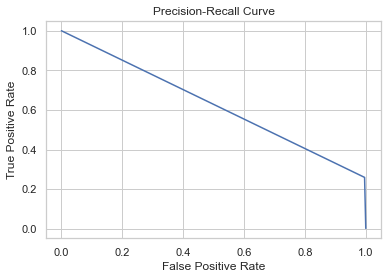

In [50]:
print ("ROC AUC Score=",roc_auc_score(y_test, y_pred_os))

auprc(y_test, y_pred_os, plot=True)

[[5064657   18829]
 [     26    6584]]


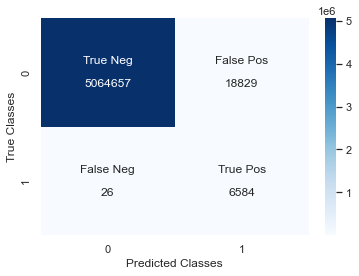

In [51]:
cf_matrix_smote = confusion_matrix(y_test,  y_pred_os)
print(cf_matrix_smote)

group_names_smote = ['True Neg','False Pos','False Neg','True Pos']
group_counts_smote = ['{0:0.0f}'.format(value) for value in
                cf_matrix_smote.flatten()]
labels_smote = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_names_smote,group_counts_smote)]
labels_smote = np.asarray(labels_smote).reshape(2,2)

sns.heatmap(cf_matrix_smote, annot=labels_smote,fmt='',cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

# To conclude...

## Let's compare the results

Text(528.6090909090908, 0.5, 'True Classes')

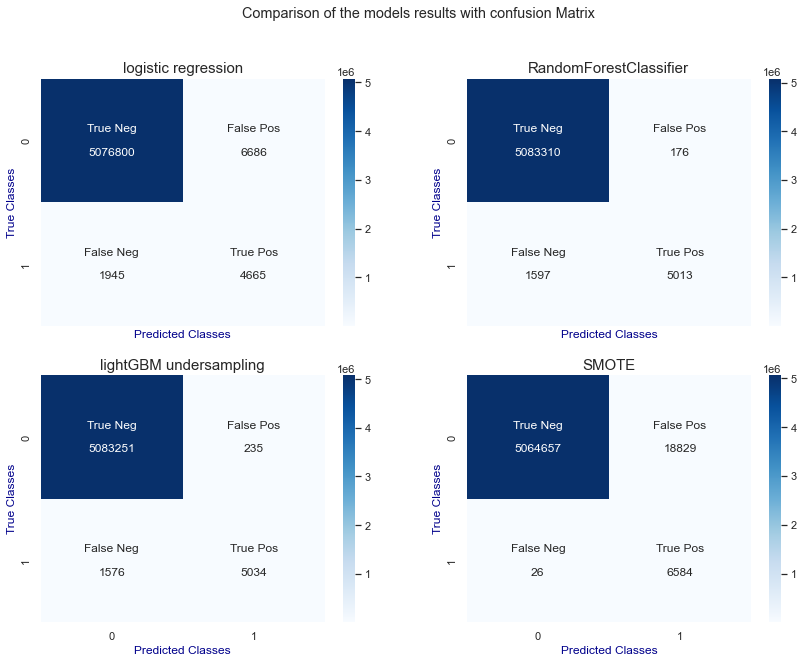

In [53]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,10))
fig.suptitle('Comparison of the models results with confusion Matrix')

#logistic regression
cf1 =sns.heatmap(cf_matrix_lr, annot=labels_lr,fmt='',cmap='Blues',ax=axes[0, 0])
cf1.set_title('logistic regression',fontsize=15)
cf1.set_xlabel("Predicted Classes",color='darkblue')
cf1.set_ylabel("True Classes",color='darkblue')

#RandomForestClassifier
cf2 = sns.heatmap(data=cf_matrix_rf, annot=labels_rf,fmt='',cmap='Blues',ax=axes[0, 1])
cf2.set_title('RandomForestClassifier',fontsize=15)
cf2.set_xlabel("Predicted Classes",color='darkblue')
cf2.set_ylabel("True Classes",color='darkblue')

#lightGBM undersampling
cf3 =sns.heatmap(cf_matrix_lg, annot=labels_lg,fmt='',cmap='Blues',ax=axes[1, 0])
cf3.set_title('lightGBM undersampling',fontsize=15)
cf3.set_xlabel("Predicted Classes",color='darkblue')
cf3.set_ylabel("True Classes",color='darkblue')

#smote
cf4 =sns.heatmap(cf_matrix_smote, annot=labels_smote,fmt='',cmap='Blues',ax=axes[1, 1])
cf4.set_title('SMOTE',fontsize=15)
cf4.set_xlabel("Predicted Classes",color='darkblue')
cf4.set_ylabel("True Classes",color='darkblue')


Notes :

- Logistic Regression :  70% of good predictions for fraudulent cases. However, approximately 7,000 transactions were detected as fraudulent when in fact they were not

- RandomForest : 75% of good predictions for fraudulent cases, but more than 1 thousand frauds has not been detected ('False Negative'). At the same time, the model detects non-fraudulent cases well.

- Undersampling with LightGBM :  76% of good predictions with a better aproach for the non-fraudulent cases with only 235 False Positive. Still needs some improvements (1.5K False Negatives)


- Oversampling with LightGBM :  99% of good predictions for fraudulent cases, but almost 20K of non fraudulent transaction were detected as fraudulent.

These models could be further optimized by playing with hyperparameters and features (examples : adding nameDest, increase the number of frauds in SMOTE...). We could also try other  models such as Decision Tree Classifier, Isolation forest or deeplearning models for example.